# CIR Model to simulate changes in Interest Rates and Liability Hedging

The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates:

$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t} dWt$$

## Short rate vs Annualized

In general, if we compound every $\frac{1}{N}$ of a year(i.e. N times a year), we get:

$$\displaystyle \Bigg (1+\frac{r}{N}\Bigg)^N$$

As N becomes very large, we get the generalization:
$$1 + r_{annual} = e^{r_{inst}}$$
i.e.
$$ r_{annual} = e^{r_{inst}}-1$$
and
$$r_{inst} = ln(1+r_{annual})$$
where inst stands for instantaneous

In [2]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    '''
    Converts short rate to an annualized rate
    '''
    return np.expm1(r)
    #return np.exp(r)-1

def ann_to_inst(r):
    '''
    Convert annualized to a short rate
    '''
    return np.log1p(r)
    #return np.log(r+1)

$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t} dWt$$

In [6]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    '''
    Implements the CIR model for interest rates
    '''
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) #int to avoid float steps
    # Generates the shock Wt
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock) # Gives an empty numpy array with size of shock
    rates[0]=r_0
    
    #Start of the simulation of the changes of rates
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # To be absolutely sure to have a positive number
        
    return pd.DataFrame(data = inst_to_ann(rates), index=range(num_steps))

In [4]:
%matplotlib inline

<AxesSubplot:>

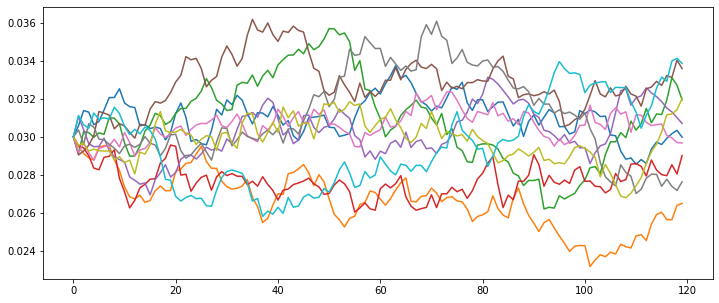

In [10]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [12]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, steps_per_year=12, n_years=10, n_scenarios=5):
    cir(n_scenarios=n_scenarios, a=a, b=b, sigma=sigma, r_0=r_0, n_years=n_years).plot(figsize=(12,5), legend=False)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                              r_0=(0,.15,.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(0,.1,.01),
                              n_scenarios=(1,100),
                              n_years=(1,20,1))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Now we have a way to change interest rates.

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_t}$$
where
$$A(t,T)= \displaystyle \Bigg (\frac{2he^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}\Bigg)^{2ab/\sigma^2}$$
and
$$B(t,T) = \frac{2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}$$
and
$$h=\sqrt{a^2+2\sigma^2}$$
and
$$\tau = T-t$$

In [23]:
import math
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    '''
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    '''
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1
    
    shock = np.random.normal(loc=0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((a+h)*ttm/2))/(2*h+(a+h)*(math.exp(ttm*h)-1)))**(2*a*b/sigma**2)
        # The np version of exp is faster when dealing with arrays, but slower on single values compared to math.exp
        _B = 2*(math.exp(ttm*h)-1)/(2*h+(a+h)*(math.exp(ttm*h)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        d_r_t = a*(b-rates[step-1])*dt+sigma*np.sqrt(rates[step-1])*shock[step]
        rates[step] = abs(rates[step-1]+d_r_t)
        prices[step] = price(n_years - step*dt, rates[step])
    
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [27]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [28]:
a_0 = .75
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(1+rates/12).cumprod()

<AxesSubplot:>

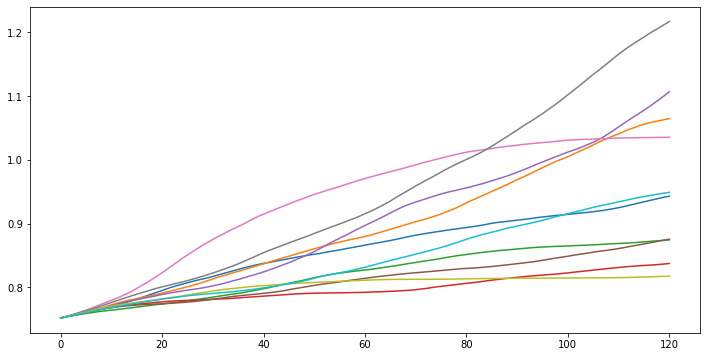

In [29]:
av_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

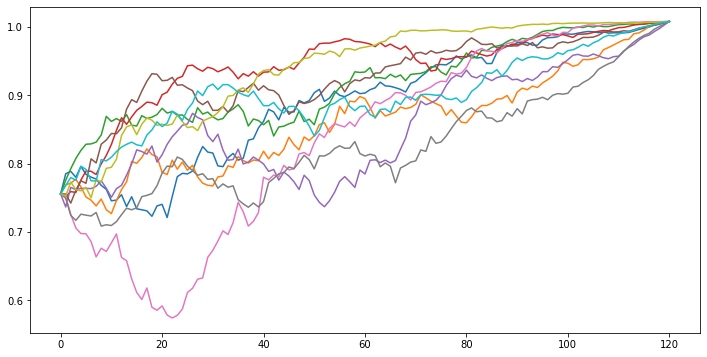

In [30]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

<AxesSubplot:title={'center':'Funding Ratio with Cash (10 scenarios)'}>

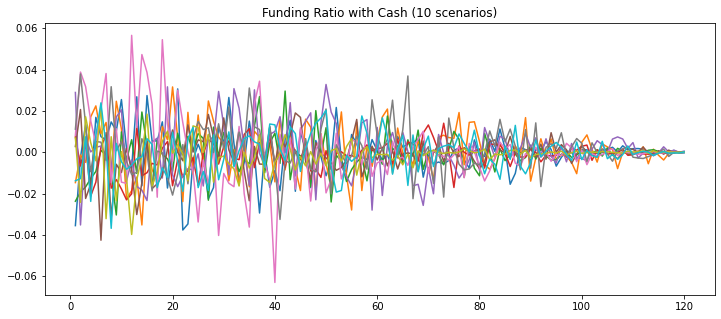

In [33]:
# Funding Ratio at any given point in time for cash
(av_cash/liabilities).pct_change().plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Funding Ratio with ZC Bonds (10 scenarios)'}>

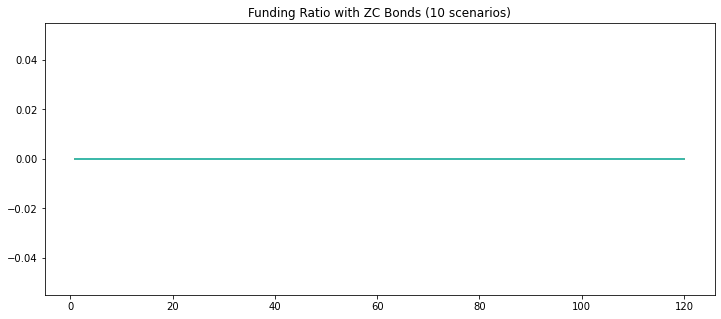

In [34]:
# Funding Ratio at any given point in time for Zero-Coupon
(av_zc_bonds/liabilities).pct_change().plot(title='Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

In [38]:
# my starting asset value today aka cash in hand
a_0 = 0.5
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:label='7fa15b90-5d2e-4b1a-b238-229aa0028fa9'>

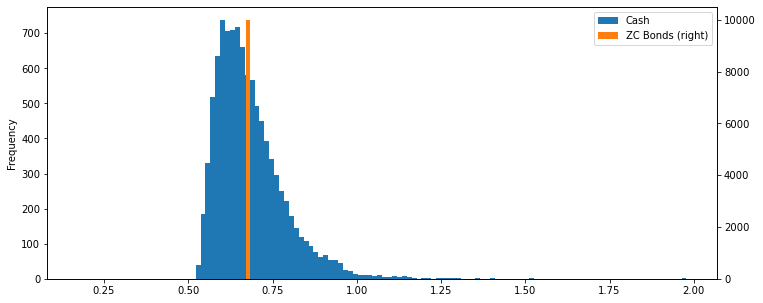

In [39]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)

We don't have enough assets to cover our liabilities in this case